In [1]:
cd /home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation

/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation


In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from sb import one_dSB_run
from multiprocessing import Pool
import os
%matplotlib inline

In [3]:
def Ising_from_maxcut_file(abs_file_path):
    """
    Import an MaxCut problem from file, and turn it into Ising form.
    
    Parameters:
        abs_file_path (str): The absolute file path for the MaxCut instance file.
    
    Return: CSR sparse matrix in Ising form.
    """
    
    with open(abs_file_path, 'r') as f:
        coef_lst = f.read().split()
    
    A = csr_matrix(([int(x) for x in coef_lst[4::3]], ([int(x)-1 for x in coef_lst[2::3]], \
                    [int(x)-1 for x in coef_lst[3::3]])), shape=(int(coef_lst[0]), int(coef_lst[0])))

    return (A + A.T)/4

In [4]:
def dSB(J, PS, dt, c0, h=None, init_y=None, sd=None):
    """
    One discrete simulated bifurcation run over the full pump schedule.
    Angular frequency (a0) is set to 1 and absorbed into PS, dt and c0.
    Objective: Minimize J.dot(state).dot(state) + h.dot(state)
    
    Parameters:
        J (2-D array of float): The matrix representing the coupling field of the problem.
        PS (list[float]): The pump strength at each step. Number of iterations is implicitly len(PS).
        dt (float): Time step for the discretized time.
        c0 (float): Positive coupling strength scaling factor.
        h (1-D array of float or None, default=None): The vector representing the local field of the problem.
        init_y (1-D array of float or None, default=None): Initial y. If None, then random numbers between 0.1 and -0.1 are chosen.
        sd (int or None, default=None): Seed for rng of init_y.
    
    Return: final_state (1-D array of float)
    """
    
    if h is None:
        j = J
    else:
        j = np.zeros((J.shape[0]+1, J.shape[1]+1))
        j[:-1, :-1] = J
        j[:-1, -1] = 0.5*h
        j[-1, :-1] = 0.5*h.T
    
    x = np.zeros(j.shape[0])

    if init_y is None:
        np.random.seed(sd)
        y = np.random.uniform(-0.1, 0.1, j.shape[0])
    else:
        y = init_y.copy()
    
    for a in PS:
        x += y * dt
        y -= ((1 - a) * x + 2 * c0 * j.dot(np.sign(x))) * dt
        for i in range(j.shape[0]): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
    
    if h is None:
        return np.sign(x)
    else:
        return np.sign(x[:-1]) * np.sign(x[-1])

In [5]:
def dSB_rev_xy(J, PS, dt, c0, h=None, init_y=None, sd=None):
    """
    One discrete simulated bifurcation run over the full pump schedule.
    Angular frequency (a0) is set to 1 and absorbed into PS, dt and c0.
    Objective: Minimize J.dot(state).dot(state) + h.dot(state)
    
    Parameters:
        J (2-D array of float): The matrix representing the coupling field of the problem.
        PS (list[float]): The pump strength at each step. Number of iterations is implicitly len(PS).
        dt (float): Time step for the discretized time.
        c0 (float): Positive coupling strength scaling factor.
        h (1-D array of float or None, default=None): The vector representing the local field of the problem.
        init_y (1-D array of float or None, default=None): Initial y. If None, then random numbers between 0.1 and -0.1 are chosen.
        sd (int or None, default=None): Seed for rng of init_y.
    
    Return: final_state (1-D array of float)
    """
    
    if h is None:
        j = J
    else:
        j = np.zeros((J.shape[0]+1, J.shape[1]+1))
        j[:-1, :-1] = J
        j[:-1, -1] = 0.5*h
        j[-1, :-1] = 0.5*h.T
    
    x = np.zeros(j.shape[0])

    if init_y is None:
        np.random.seed(sd)
        y = np.random.uniform(-0.1, 0.1, j.shape[0])
    else:
        y = init_y.copy()
    
    for a in PS:
        y -= ((1 - a) * x + 2 * c0 * j.dot(np.sign(x))) * dt
        x += y * dt
        for i in range(j.shape[0]): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
    
    if h is None:
        return np.sign(x)
    else:
        return np.sign(x[:-1]) * np.sign(x[-1])

In [6]:
# J matirces from maxcut problem files
J_dict = dict()
for N in [60, 80, 100]:
    for ins in range(10):
        abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
        J_dict[(N, ins)] = Ising_from_maxcut_file(abs_file_path)

In [7]:
# best known solution for the g05 dataset
opt_cut = {60: [536, 532, 529, 538, 527, 533, 531, 535, 530, 533], \
           80: [929, 941, 934, 923, 932, 926, 929, 929, 925, 923], \
           100: [1430, 1425, 1432, 1424, 1440, 1436, 1434, 1431, 1432, 1430]}

In [8]:
def get_cut_val(N, ins, PS, dt, c0, y0, normalize_J=True, rng=None, fun=dSB):
    # abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
    # J = Ising_from_maxcut_file(abs_file_path)
    J = J_dict[(N, ins)]

    if normalize_J:
        j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalization
    
    if isinstance(PS, int): # number of iterations
        ps = [i/(PS-1) for i in range(PS)] # linear schedule from 0 to 1
    else:
        ps = list(PS)

    if rng is not None:
        init_y = y0 * rng.uniform(low=-1, high=1, size=j.shape[0])
        # init_y = y0 * rng.normal(size=j.shape[0])
        # init_y = y0 * (2*rng.integers(0, high=2, size=J.shape[0])-1) # initialize in \pm y0
    else:
        init_y = y0 * np.ones(j.shape[0])

    fin_state = fun(j, ps, dt, c0, init_y=init_y)
    fin_energy = fin_state.dot(J.dot(fin_state))

    return int(np.sum(J) - fin_energy) # cut value

In [9]:
dt_lst = [0.25, 0.5, 0.75, 1.0, 1.25]
c0_lst = [6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

In [10]:
num_rep = 1000
args_lst = []
for dt in dt_lst:
    for c0 in c0_lst:
        for N in [60, 80, 100]:
            for ins in range(10):
                for _ in range(num_rep):
                    args_lst.append((N, ins, dt, c0))

## calculate increments of x first and then y

In [226]:
rng = np.random.default_rng(0)

In [227]:
def wrapper(args):
    N, ins, dt, c0 = args
    J = J_dict[(N, ins)]
    PS = int(150/dt)
    return get_cut_val(N, ins, PS, dt, c0, 0.01, rng=rng)

In [228]:
with Pool(os.cpu_count()//2) as p:
    results = list(tqdm(p.imap(wrapper, args_lst), total=len(args_lst)))

100%|██████████| 750000/750000 [16:58<00:00, 736.55it/s] 


In [274]:
avg_cut_vals = dict()
best_cut_vals = dict()
best_counts = dict()
for args in args_lst:
    avg_cut_vals[args] = 0
    best_cut_vals[args] = 0
    best_counts[args] = 0

for args, cut_val in zip(args_lst, results):
    avg_cut_vals[args] += cut_val / num_rep
    best_cut_vals[args] = max(best_cut_vals[args], cut_val)
    if cut_val == opt_cut[args[0]][args[1]]:
        best_counts[args] += 1

In [275]:
# average over instances
avg_cut_vals_2 = dict()
best_counts_2 = dict()
best_err_rate_2 = dict()
for (N, ins, dt, c0) in avg_cut_vals.keys():
    avg_cut_vals_2[(N, dt, c0)] = 0
    best_counts_2[(N, dt, c0)] = 0
    best_err_rate_2[(N, dt, c0)] = 0

for (N, ins, dt, c0) in avg_cut_vals.keys():
    avg_cut_vals_2[(N, dt, c0)] += avg_cut_vals[(N, ins, dt, c0)] / 10
    best_counts_2[(N, dt, c0)] += best_counts[(N, ins, dt, c0)]
    best_err_rate_2[(N, dt, c0)] += (1 - best_cut_vals[(N, ins, dt, c0)] / opt_cut[N][ins]) / 10

([<matplotlib.axis.XTick at 0x7f212f949190>,
 [Text(60, 0, '60'), Text(80, 0, '80'), Text(100, 0, '100')])

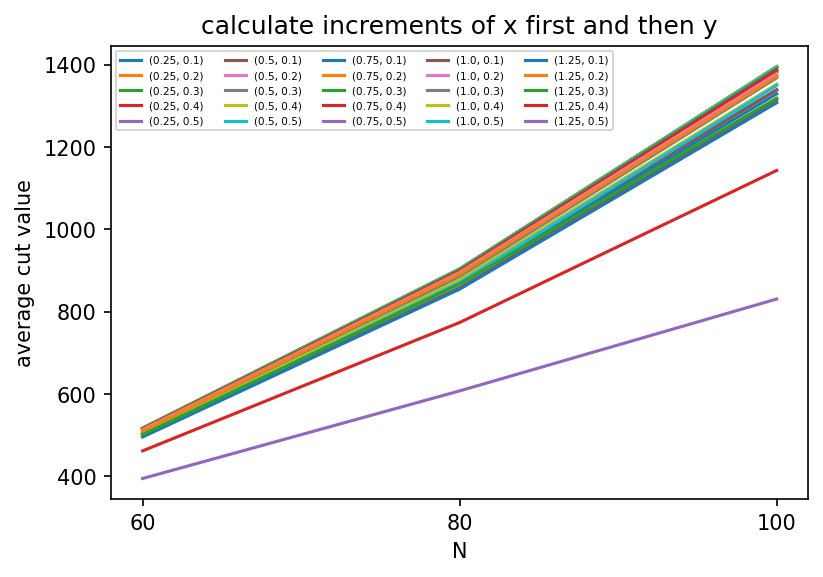

In [264]:
xdata = [60, 80, 100]

plt.figure(dpi=150)
for dt in dt_lst:
    for c0 in c0_lst:
        ydata = [avg_cut_vals_2[(N, dt, c0)] for N in xdata]
        plt.plot(xdata, ydata, label=f'({dt}, {c0})')
plt.xlabel("N")
plt.ylabel("average cut value")
plt.title("calculate increments of x first and then y")
plt.legend(loc='upper left', ncol=5, fontsize=5)
plt.xticks(xdata, xdata)

([<matplotlib.axis.XTick at 0x7f212a987790>,
 [Text(60, 0, '60'), Text(80, 0, '80'), Text(100, 0, '100')])

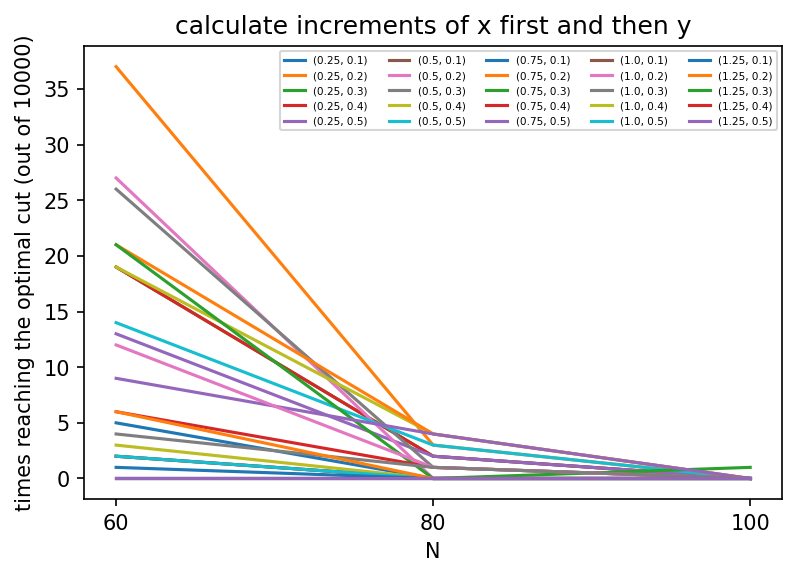

In [265]:
xdata = [60, 80, 100]

plt.figure(dpi=150)
for dt in dt_lst:
    for c0 in c0_lst:
        ydata = [best_counts_2[(N, dt, c0)] for N in xdata]
        plt.plot(xdata, ydata, label=f'({dt}, {c0})')
plt.xlabel("N")
plt.ylabel("times reaching the optimal cut (out of 10000)")
plt.title("calculate increments of x first and then y")
plt.legend(loc='upper right', ncol=5, fontsize=5)
plt.xticks(xdata, xdata)

In [276]:
best = -1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_counts_2[(60, dt, c0)] > best:
            best = best_counts_2[(60, dt, c0)]
            best_args = [(dt, c0)]
        elif best_counts_2[(60, dt, c0)] == best:
            best_args.append((dt, c0))
best_args, best_counts_2[(60, best_args[0][0], best_args[0][1])] # for N = 60

([(0.25, 0.2)], 37)

In [277]:
best = -1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_counts_2[(80, dt, c0)] > best:
            best = best_counts_2[(80, dt, c0)]
            best_args = [(dt, c0)]
        elif best_counts_2[(80, dt, c0)] == best:
            best_args.append((dt, c0))
best_args, best_counts_2[(80, best_args[0][0], best_args[0][1])] # for N = 80

([(0.5, 0.4), (0.75, 0.2), (0.75, 0.5)], 4)

In [278]:
best = -1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_counts_2[(100, dt, c0)] > best:
            best = best_counts_2[(100, dt, c0)]
            best_args = [(dt, c0)]
        elif best_counts_2[(100, dt, c0)] == best:
            best_args.append((dt, c0))
best_args, best_counts_2[(100, best_args[0][0], best_args[0][1])] # for N = 100

([(0.75, 0.3)], 1)

(0.0, 0.02)

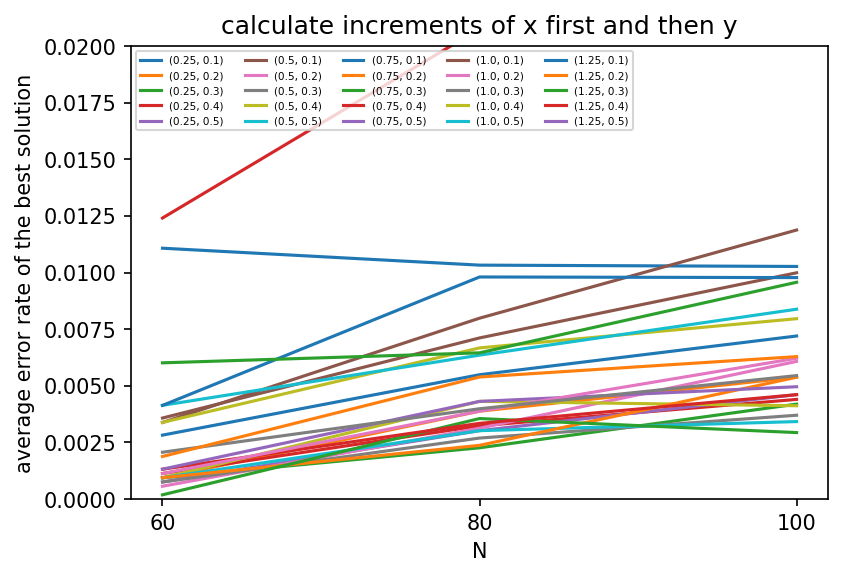

In [243]:
xdata = [60, 80, 100]

plt.figure(dpi=150)
for dt in dt_lst:
    for c0 in c0_lst:
        ydata = [best_err_rate_2[(N, dt, c0)] for N in xdata]
        plt.plot(xdata, ydata, label=f'({dt}, {c0})')
plt.xlabel("N")
plt.ylabel("average error rate of the best solution")
plt.title("calculate increments of x first and then y")
plt.legend(loc='upper left', ncol=5, fontsize=5)
plt.xticks(xdata, xdata)
plt.ylim(0, 0.02)

In [246]:
best = 1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_err_rate_2[(60, dt, c0)] < best:
            best = best_err_rate_2[(60, dt, c0)]
            best_args = [(dt, c0)]
        elif best_err_rate_2[(60, dt, c0)] == best:
            best_args.append((dt, c0))
best_args # for N = 60

[(0.75, 0.3)]

In [240]:
best = 1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_err_rate_2[(80, dt, c0)] < best:
            best = best_err_rate_2[(80, dt, c0)]
            best_args = [(dt, c0)]
        elif best_err_rate_2[(80, dt, c0)] == best:
            best_args.append((dt, c0))
best_args # for N = 80

[(0.25, 0.3)]

In [241]:
best = 1
for dt in dt_lst:
    for c0 in c0_lst:
        if best_err_rate_2[(100, dt, c0)] < best:
            best = best_err_rate_2[(100, dt, c0)]
            best_args = [(dt, c0)]
        elif best_err_rate_2[(100, dt, c0)] == best:
            best_args.append((dt, c0))
best_args # for N = 100

[(0.75, 0.3)]

## calculate increments of y first and then x
this is the way

### Experimenting different params and graphing

In [11]:
rng = np.random.default_rng(0)

In [12]:
def wrapper(args):
    N, ins, dt, c0 = args
    J = J_dict[(N, ins)]
    PS = int(150/dt)
    return get_cut_val(N, ins, PS, dt, c0, 0.01, rng=rng, fun=dSB_rev_xy)

In [405]:
with Pool(os.cpu_count()//2) as p:
    results_rev = list(tqdm(p.imap(wrapper, args_lst), total=len(args_lst)))

100%|██████████| 1200000/1200000 [40:28<00:00, 494.09it/s] 


In [408]:
# storing the results
with open('benchmark_results.csv', 'a') as f:
    # f.write(f"N,ins,dt,c0,results")
    prev_args = None
    for args, cut in zip(args_lst, results_rev):
        N, ins, dt, c0 = args
        if prev_args != args:
            f.write(f"\n{N},{ins},{dt},{c0},{cut}")
            prev_args = args
        else:
            f.write(f",{cut}")

In [24]:
# retrieving the results from csv file
data = dict() # cut values
with open('benchmark_results.csv', 'r') as f:
    header = f.readline()
    line = f.readline()
    while line:
        entries = line.split(',')
        N = int(entries[0])
        ins = int(entries[1])
        dt = float(entries[2])
        c0 = float(entries[3])
        if (N, ins, dt, c0) not in data:
            data[(N, ins, dt, c0)] = [int(x) for x in entries[4:]]
        else:
            data[(N, ins, dt, c0)].extend([int(x) for x in entries[4:]])
        line = f.readline()

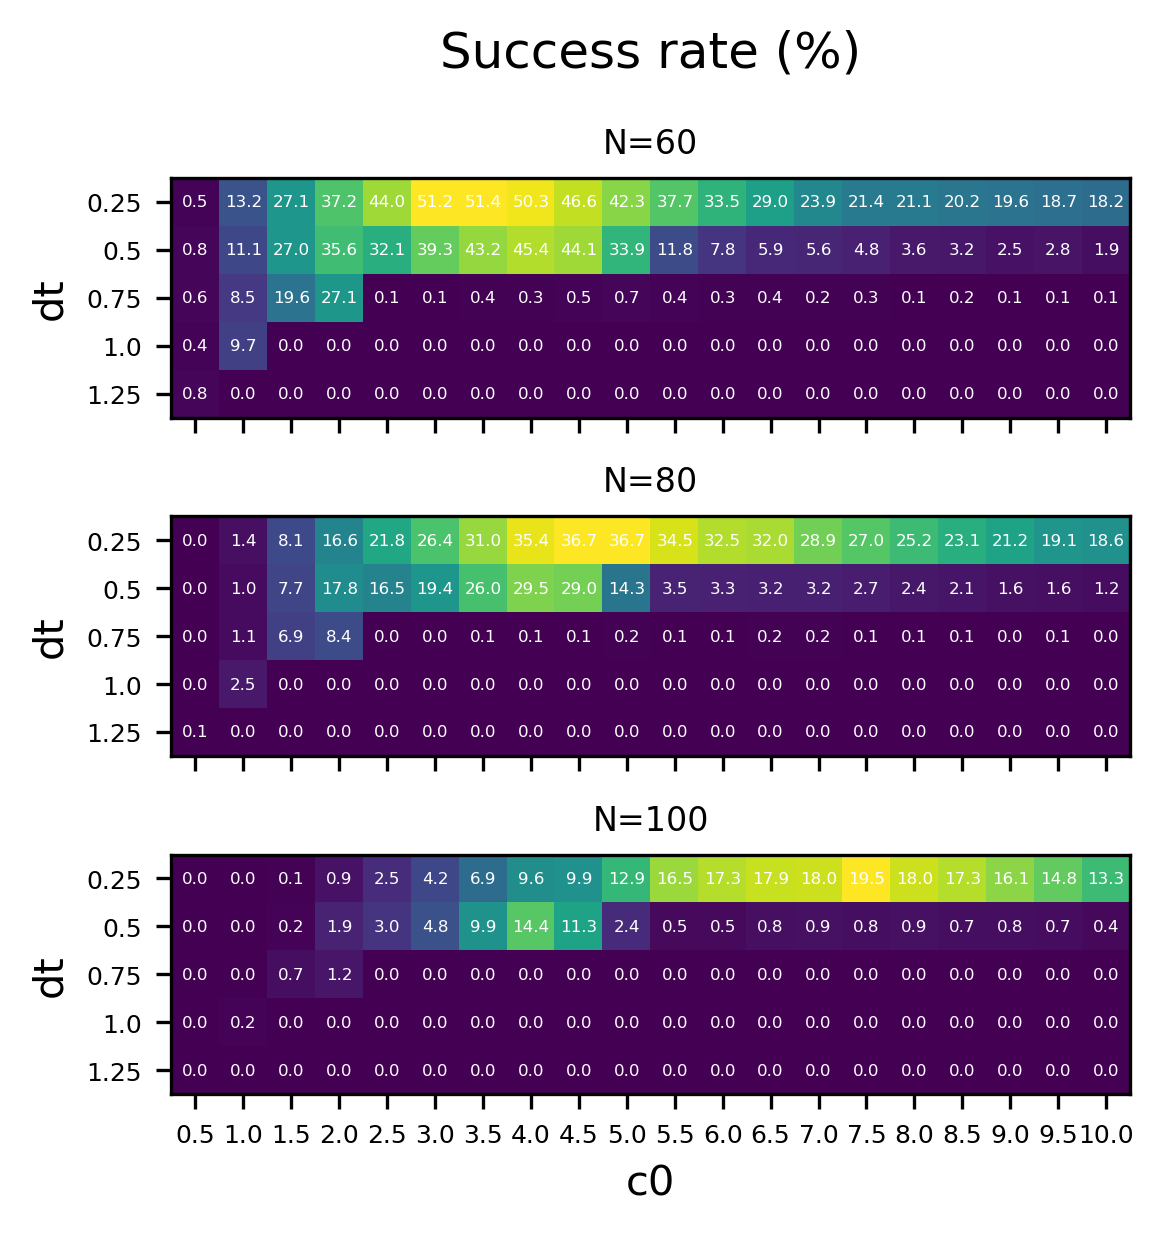

In [58]:
fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("Success rate (%)")
plt.setp(axs[-1], xlabel="c0")
plt.setp(axs[:], ylabel="dt")

xdata = [0.5*(x+1) for x in range(20)] # c0
ydata = [0.25, 0.5, 0.75, 1.0, 1.25] # dt

for i, N in enumerate([60, 80, 100]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(ydata), len(xdata)))
    total_count_data = np.zeros((len(ydata), len(xdata)))
    for ins in range(10):
        for x, c0 in enumerate(xdata):
            for y, dt in enumerate(ydata):
                best_cut_count_data[y, x] += sum([x == opt_cut[N][ins] for x in data[(N, ins, dt, c0)]])
                total_count_data[y, x] += len(data[(N, ins, dt, c0)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(xdata)))
    ax.set_yticks(np.arange(len(ydata)))
    ax.set_xticklabels(xdata, size=6)
    ax.set_yticklabels(ydata, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"N={N}", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ydata)):
        for j in range(len(xdata)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

# fig, ax = plt.subplots()
# im = ax.imshow(harvest)

# # Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(farmers)), labels=farmers)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# ax.set_title("Harvest of local farmers (in tons/year)")
# fig.tight_layout()
# plt.show()

### Trying to estimate the success rate

In [406]:
avg_cut_vals = dict()
best_cut_vals = dict()
best_counts = dict()
for args in args_lst:
    avg_cut_vals[args] = 0
    best_cut_vals[args] = 0
    best_counts[args] = 0

for args, cut_val in zip(args_lst, results_rev):
    avg_cut_vals[args] += cut_val / num_rep
    best_cut_vals[args] = max(best_cut_vals[args], cut_val)
    if cut_val == opt_cut[args[0]][args[1]]:
        best_counts[args] += 1

In [407]:
# average over instances
avg_cut_vals_2 = dict()
best_counts_2 = dict()
best_err_rate_2 = dict()
for (N, ins, dt, c0) in avg_cut_vals.keys():
    avg_cut_vals_2[(N, dt, c0)] = 0
    best_counts_2[(N, dt, c0)] = 0
    best_err_rate_2[(N, dt, c0)] = 0

for (N, ins, dt, c0) in avg_cut_vals.keys():
    avg_cut_vals_2[(N, dt, c0)] += avg_cut_vals[(N, ins, dt, c0)] / 10
    best_counts_2[(N, dt, c0)] += best_counts[(N, ins, dt, c0)]
    best_err_rate_2[(N, dt, c0)] += (1 - best_cut_vals[(N, ins, dt, c0)] / opt_cut[N][ins]) / 10

([<matplotlib.axis.XTick at 0x7f2125bd8e10>,
 [Text(60, 0, '60'), Text(80, 0, '80'), Text(100, 0, '100')])

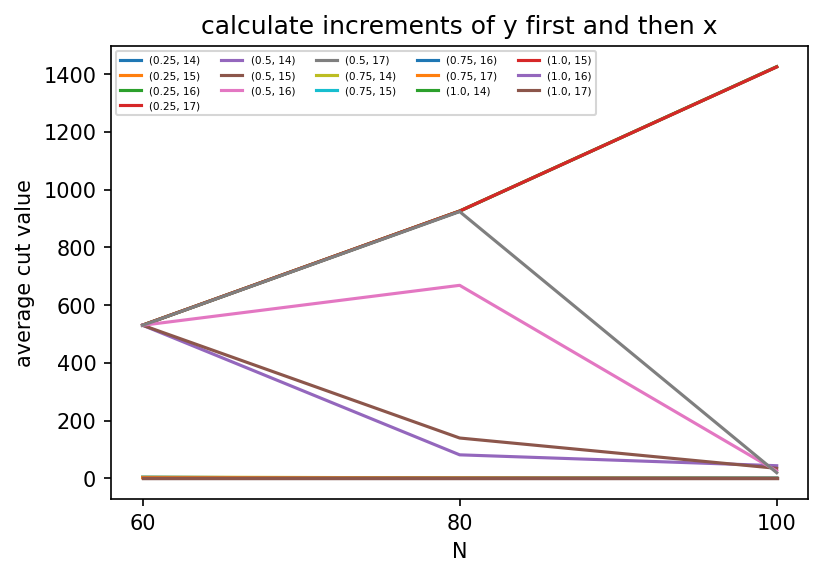

In [388]:
xdata = [60, 80, 100]

plt.figure(dpi=150)
for dt in dt_lst:
    for c0 in c0_lst:
        ydata = [avg_cut_vals_2[(N, dt, c0)] for N in xdata]
        plt.plot(xdata, ydata, label=f'({dt}, {c0})')
plt.xlabel("N")
plt.ylabel("average cut value")
plt.title("calculate increments of y first and then x")
plt.legend(loc='upper left', ncol=5, fontsize=5)
plt.xticks(xdata, xdata)

([<matplotlib.axis.XTick at 0x7f2125b51410>,
 [Text(60, 0, '60'), Text(80, 0, '80'), Text(100, 0, '100')])

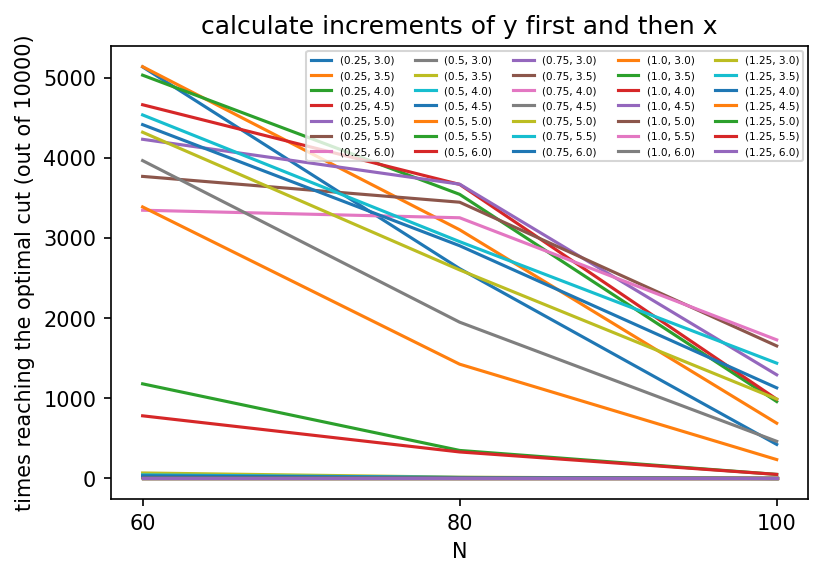

In [366]:
xdata = [60, 80, 100]

plt.figure(dpi=150)
for dt in dt_lst:
    for c0 in c0_lst:
        ydata = [best_counts_2[(N, dt, c0)] for N in xdata]
        plt.plot(xdata, ydata, label=f'({dt}, {c0})')
plt.xlabel("N")
plt.ylabel("times reaching the optimal cut (out of 10000)")
plt.title("calculate increments of y first and then x")
plt.legend(loc='upper right', ncol=5, fontsize=5)
plt.xticks(xdata, xdata)

Assuming success rate is $p=0.05$ for each run, we will need $\frac{\log(1-0.99)}{\log(1-0.05)} \approx 90$ runs to reach an expected success rate of 0.99

### Seems like whether to calculate the increments of x or y first really does affect the behavior of dSB

### The results were so bad, lets see what's going on (Jul. 14)
Seems like there's no bifurcation. Oscillatory behavior persists to the end.

- Q: Maybe the formulation of J is wrong?
- A: Yes it was. J should be (and is now) symmetric.

In [399]:
N = 60
ins = 0
abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
J = Ising_from_maxcut_file(abs_file_path)
j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalization

y0 = 0.01
rng = np.random.default_rng(0)
init_y = y0 * rng.uniform(size=j.shape[0])
# init_y = y0 * (2*rng.integers(0, high=2, size=J.shape[0])-1) # initialize in \pm y0

dt, c0 = 0.25, 6.0
result, x_history = one_dSB_run(j, [i/(int(100/dt)-1) for i in range(int(150/dt))], dt, c0, init_y=init_y, return_x_history=True)

Text(0, 0.5, 'x')

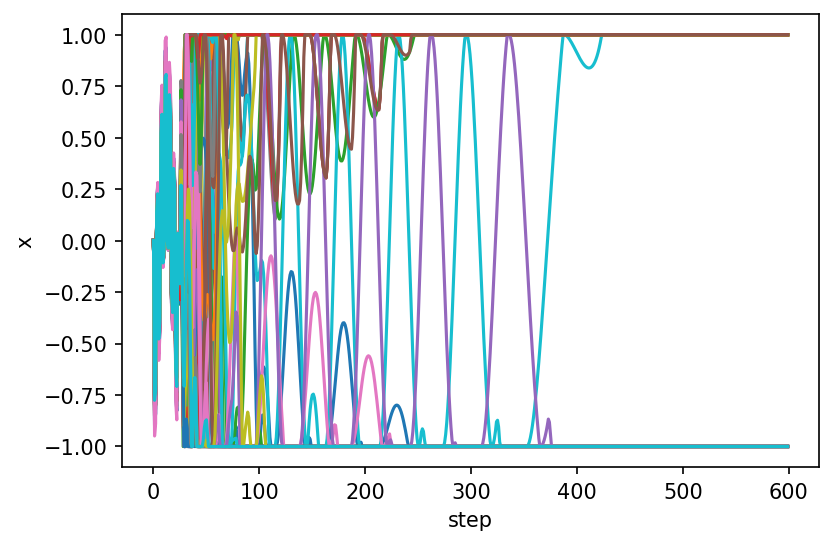

In [400]:
plt.figure(dpi=150)

for i in range(N):
    plt.plot(np.array(x_history)[:, i], label=f'{i}')

plt.xlabel('step')
plt.ylabel('x')

### Optimize parameters with scipy.optimize.minimize
Optimization failed hard. One of the reasons might be that some parameters are discrete

In [29]:
def get_err_rate(N, num_rep, PS, dt, c0, y0):
    err_rate = 0
    for ins in range(10):
        avg_cut = 0
        for sd in range(num_rep):
            avg_cut += get_cut_val(N, ins, PS, dt, c0, y0, rand_sd=sd) / num_rep
        err_rate += (1 - avg_cut / opt_cut[N][ins]) / 10
    return err_rate

In [30]:
def wrapper(args):
    N = 60
    num_rep = 5
    PS, dt, c0, y0 = args
    print(args)
    return get_err_rate(N, num_rep, PS, dt, c0, y0)

In [35]:
result = minimize(wrapper, (3600, 0.01, 0.5, 0.05), bounds=((10, None), (0, None), (0, 1), (None, None)), method='Nelder-Mead')

[3.6e+03 1.0e-02 5.0e-01 5.0e-02]
[3.78e+03 1.00e-02 5.00e-01 5.00e-02]
[3.60e+03 1.05e-02 5.00e-01 5.00e-02]


In [36]:
result

 final_simplex: (array([[3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02],
       [3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02],
       [3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02],
       [3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02],
       [3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02]]), array([0.92607303, 0.92633598, 0.92637675, 0.92655993, 0.92671391]))
           fun: 0.9260730270596864
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 801
           nit: 300
        status: 1
       success: False
             x: array([3.68033840e+03, 9.78905267e-03, 4.98578004e-01, 4.97577835e-02])